<div style="border-radius: 5px; padding: 1rem; margin-bottom: 1rem">
<img src="https://www.prototypesforhumanity.com/wp-content/uploads/2022/11/LOGO_UTEC_.png" alt="Banner" width="150" />   
 </div>

# Laboratorio 8: Vectorización, Indexación y Reconocimiento de Rostros

> **Prof. Heider Sanchez**  
> **ACLs:** Ana María Accilio, Sebastián Loza

## Introducción

Las imágenes, y específicamente los rostros, representan uno de los tipos más complejos de datos no estructurados, requiriendo técnicas especializadas para su procesamiento y recuperación eficiente.

El manejo de datos biométricos faciales presenta varios retos:
- La necesidad de convertir información visual compleja en representaciones numéricas procesables.
- El almacenamiento eficiente de vectores de alta dimensionalidad (vectores característicos faciales).
- La implementación de búsquedas rápidas y precisas en grandes colecciones de datos.

Este laboratorio aborda estos desafíos explorando diferentes técnicas de indexación vectorial para optimizar la búsqueda de rostros similares. 

El proceso general consiste en:

1. **Vectorización de rostros**: Utilizando la biblioteca `face_recognition`, convertiremos imágenes de rostros en vectores de características (embeddings) de 128 dimensiones que capturan los rasgos faciales distintivos.

2. **Indexación**: Exploraremos diferentes estructuras de indexación para almacenar y buscar eficientemente estos vectores:
   - Búsqueda lineal (fuerza bruta)
   - Índice Multidimensional con GiST
   - Índice de Alta Dimensión con pgvector
   
3. **Búsqueda de similitud**: Implementaremos búsquedas de k vecinos más cercanos (k-NN) para encontrar rostros similares a una imagen de consulta.


## P1. Desempeño del GiST (RTree) en Altas Dimensiones
Vamos empezar el laboratorio evaluando el desempeño del índice multidimensional GIST de PostgreSQL para diferentes dimensiones del vector característico.

- Crear una tabla con dos campos de tipo "cube".
- Poblar la tabla con N puntos aleatorios de D dimensiones en ambos campos.  
  - $N = 10^6$
  - $D = [2,4,6,8,16,32,64]$
- Luego proceder a crear el índice gist sobre uno de ellos.
- Realizar un análisis comparativo de los tiempos de la búsqueda KNN secuencial y la búsqueda KNN indexada para $K=3$.
- Ambas búsquedas, secuencial e indexada, deben usar la misma consulta SQL pero en diferentes campos.
- Capturar los tiempos del plan de ejecución y elabore la tabla de resultados de forma similar a la tabla del apartado anterior.

- Elaborar un gráfico comparativo para responder la siguiente pregunta:  
  - ¿Hasta qué dimensión D conviene usar el RTree para búsquedas KNN en lugar de la búsqueda lineal?  


#### Tutorial de Uso de GiST en PostgreSQL

```sql
create extension cube;

-- create a table with two vectors
create table vectors (id serial, vector_lineal cube, vector_gist cube);

-- Populate table with random data for D=8:
insert into vectors(id, vector_lineal)
    select id,
	cube(ARRAY[round(random()*1000), 
			round(random()*1000),
			round(random()*1000), 
			round(random()*1000), 
			round(random()*1000), 
			round(random()*1000), 
 			round(random()*1000), 
 			round(random()*1000)])
	from generate_series(1, 10000) id;

update vectors set vector_gist = vector_lineal;	

-- create the index
CREATE INDEX idx_vectorind ON vectors USING gist(vector_gist);

--- KNN lineal scan
explain analyze
SELECT id, vector_lineal, 
		cube_distance(vector_lineal, '(636, 616, 153, 907, 142, 900, 773, 502)') as D
FROM vectors
ORDER BY vector_lineal <-> '(636, 616, 153, 907, 142, 900, 773, 502)'
LIMIT 5;

--- KNN using the index
explain analyze
SELECT id, vector_gist, 
		cube_distance(vector_gist, '(636, 616, 153, 907, 142, 900, 773, 502)') as D
FROM vectors
ORDER BY vector_gist <-> '(636, 616, 153, 907, 142, 900, 773, 502)'
LIMIT 5;
```

In [1]:
# Solución Aquí

## P2. Cargar el Dataset de Rostros

### Instalación de dependencias

Antes de comenzar, necesitamos instalar las siguientes librerías en Python:

```bash
# Instalar face_recognition (incluye dlib)
conda install -c conda-forge face_recognition

# Instalar librerías para manipulación de datos y visualización
pip install pandas numpy matplotlib

# Instalar Rtree para indexación espacial
pip install Rtree
```

> **Nota**: La instalación de `face_recognition` puede ser compleja en Windows. Se recomienda usar conda para facilitar la instalación de las dependencias.


### Descarga del dataset
Descargar [LFW Dataset](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data) y descomprimir en una carpeta localmente.


In [7]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rtree import index
import face_recognition

DATASET_PATH = "/Users/obed/Desktop/lab8/lfw_funneled"

coleccion = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = os.path.basename(os.path.dirname(path))  # <-- más robusto para rutas
    coleccion.append({"person": person, "path": path})

coleccion = pd.DataFrame(coleccion)
coleccion.head(10)
coleccion.shape

(13233, 2)

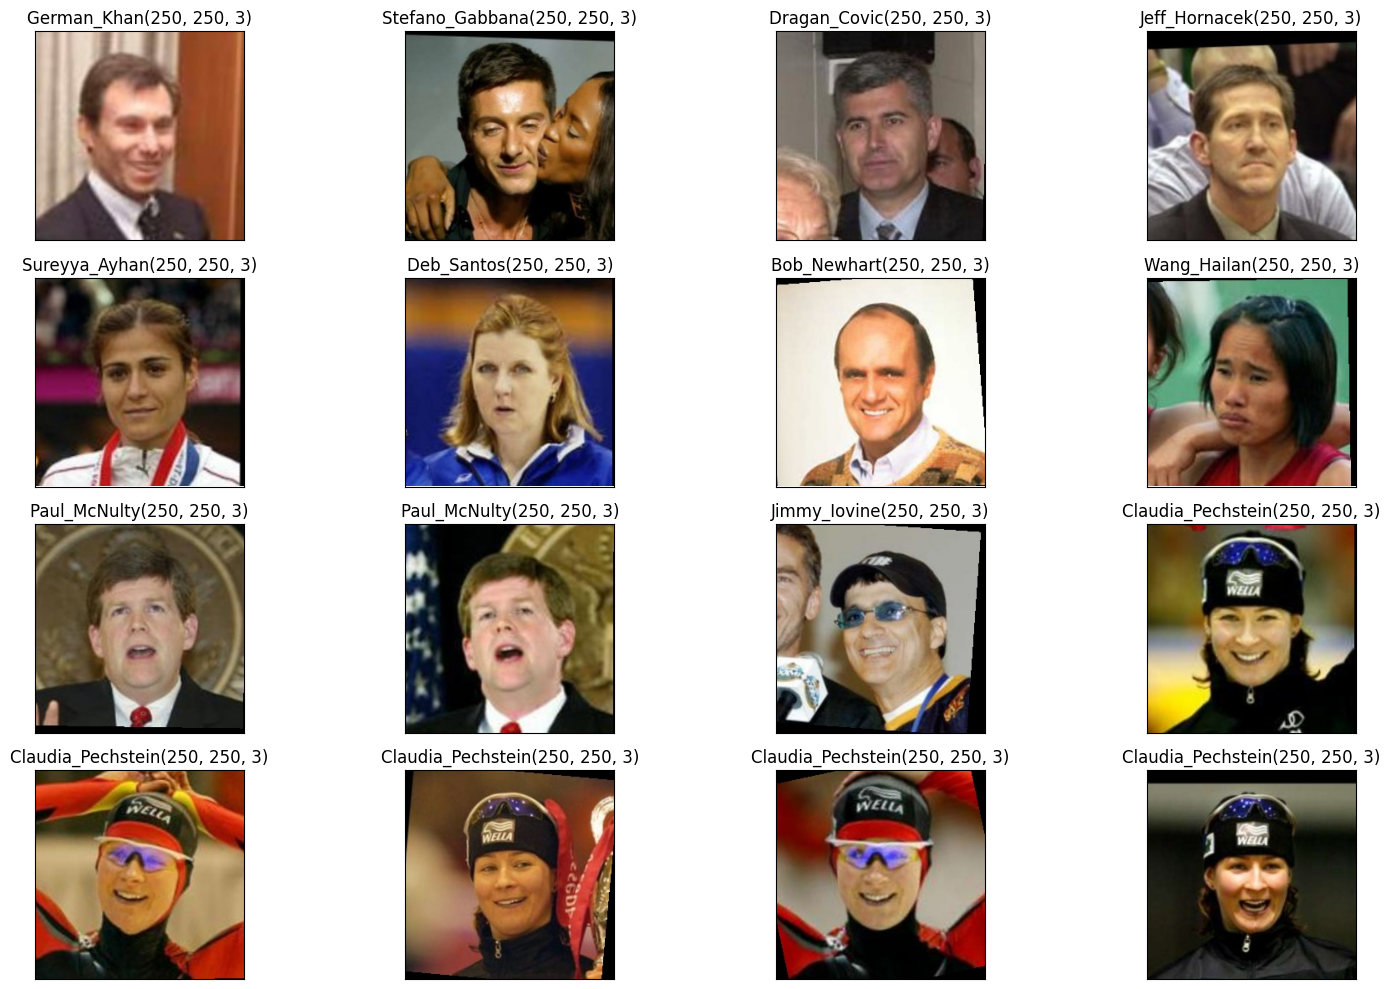

In [8]:
def mostrarFotos(coleccion, indices):
    plt.figure(figsize=(16,10))
    i = 0
    for idx in indices:
        img = plt.imread(coleccion.path.iloc[idx])
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title(coleccion.person.iloc[idx]+str(img.shape))
        plt.xticks([])
        plt.yticks([])
        i += 1
    plt.tight_layout()
    plt.show()

#indices = np.random.randint(0, len(coleccion), 5)
indices = list(range(0, 16))
mostrarFotos(coleccion, indices)


## P3. Generar los vectores característicos

En esta etapa, convertiremos las imágenes de rostros en vectores numéricos (embeddings) que representan las características faciales. El proceso consiste en:

1. **Extracción de características**: Usando la biblioteca `face_recognition`, cada imagen se procesa para:
   - Detectar la ubicación del rostro
   - Extraer un vector de 128 dimensiones que captura las características faciales distintivas

2. **Almacenamiento**: Los vectores generados se almacenan en PostgreSQL:
   - Evitar reprocesar las imágenes en cada ejecución
   - Permitir la reutilización de los embeddings en diferentes técnicas de búsqueda

La función `generate_face_embeddings()` debe implementar este proceso:
- Recibe una colección de imágenes y el número N de rostros a procesar
- Genera los embeddings faciales usando el modelo pre-entrenado de `face_recognition`
- Guarda los resultados en base de datos.

In [9]:
# Cargar las imágenes y extraer embeddings faciales
def generate_face_embeddings(coleccion, N):
    embeddings = []
    image_filenames = []    
    for index, row in coleccion.head(N).iterrows():
        filename = row['path']
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = face_recognition.load_image_file(filename)            
            # Extraer los embeddings faciales
            face_encodings = face_recognition.face_encodings(image)
            if face_encodings:
                # Tomamos el primer rostro detectado en la imagen (si hay varios, solo tomamos uno)
                embeddings.append(face_encodings[0])
                image_filenames.append(row['person'])    
    embeddings = np.array(embeddings)    
    return embeddings, image_filenames

# Cargar embeddings de la colección de fotos
embeddings, image_filenames = generate_face_embeddings(coleccion, N=500)
print(f"Se encontraron {len(embeddings)} rostros en las imágenes.")

Se encontraron 500 rostros en las imágenes.


In [14]:
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:01:02


In [16]:

import psycopg2
conn = psycopg2.connect(
    dbname='lab8',
    user='postgres',
    password='123',
    host='localhost',
    port='5432'
)
cur = conn.cursor()

for person, embedding in zip(image_filenames, embeddings):
    embedding_list = embedding.tolist()
    cur.execute(
        "INSERT INTO face_embeddings (person_name, embedding) VALUES (%s, %s)",
        (person, embedding_list)
    )

conn.commit()
cur.close()
conn.close()

## P4: Búsqueda KNN Lineal

En este paso implementaremos el método más básico de búsqueda de vecinos más cercanos (k-NN) utilizando una búsqueda lineal:

1. **Procesamiento de consulta**:
   - Cargar la imagen de consulta
   - Extraer su vector de características usando `face_recognition`

2. **Búsqueda de similitud**:
   - Comparar el vector de consulta con cada vector en la colección utilizando el operador `<->`
   - Ordenar los resultados por distancia y retornar los k vectores más cercanos

Aunque este método es simple de implementar, su complejidad es O(n) ya que requiere comparar con todos los vectores de la colección.

In [26]:
import face_recognition
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
# 🚀 1️⃣ Procesamiento de consulta
ruta = "/Users/obed/Desktop/lab8/query.jpeg"
query_image = face_recognition.load_image_file(ruta)
query_encodings = face_recognition.face_encodings(query_image)



if len(query_encodings) == 0:
    print("No se detectó ningún rostro en la imagen de consulta.")
    exit()

query_embedding = query_encodings[0]



# 🚀 2️⃣ Leer embeddings de la base de datos
conn = psycopg2.connect(
    dbname='lab8',
    user='postgres',
    password='123',
    host='localhost',
    port='5432'
)
cur = conn.cursor()
cur.execute("SELECT person_name, embedding FROM face_embeddings")
rows = cur.fetchall()
cur.close()
conn.close()

# 🚀 3️⃣ Convertir a NumPy
names = []
embeddings = []
for name, emb in rows:
    names.append(name)
    embeddings.append(emb)

embeddings = np.array(embeddings)

# 🚀 4️⃣ Calcular distancias (búsqueda lineal)
distances = np.linalg.norm(embeddings - query_embedding, axis=1)

# 🚀 5️⃣ Encontrar los k más cercanos
k = 5
nearest_indices = np.argsort(distances)[:k]

print("\nVecinos más cercanos:")
for idx in nearest_indices:
    print(f"Persona: {names[idx]} - Distancia: {distances[idx]:.4f}")


Vecinos más cercanos:
Persona: Claudia_Pechstein - Distancia: 0.5847
Persona: Claudia_Pechstein - Distancia: 0.6508
Persona: Claudia_Pechstein - Distancia: 0.6603
Persona: Salma_Hayek - Distancia: 0.6719
Persona: Liza_Minnelli - Distancia: 0.6964


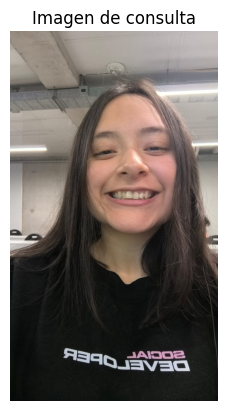

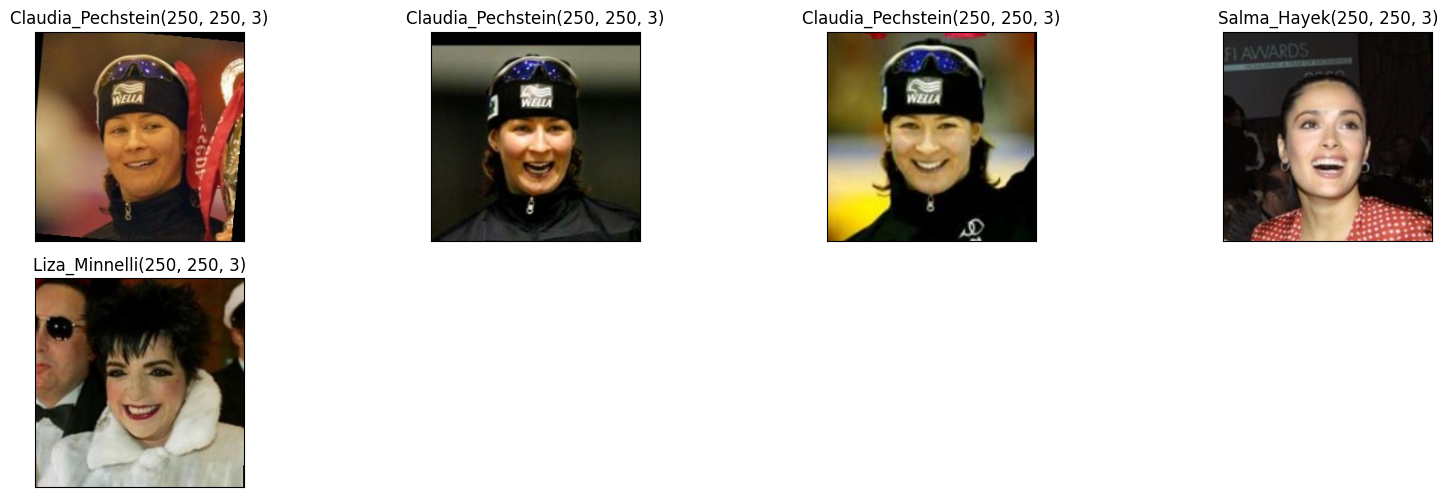

In [27]:
# 🚀 Mostrar la imagen de la consulta
plt.imshow(query_image)
plt.title("Imagen de consulta")
plt.axis("off")
plt.show()
mostrarFotos(coleccion, nearest_indices)

## P5. Búsqueda KNN usando GiST de PostgreSQL

En este paso implementaremos la búsqueda KNN utilizando el índice GiST creado para el campo que almacena los vectores caracteristicos del rostro. 

Se espera que esta implementación ofrezca mejor rendimiento que la búsqueda lineal, ya que el R-Tree optimiza la búsqueda reduciendo el espacio de búsqueda usando su estructura jerárquica.

In [5]:
# Solución Aquí

## P6. Búsqueda KNN usando PyVector de PostgreSQL

En este paso implementaremos la búsqueda KNN utilizando PostgreSQL con la extensión `pgvector`, que proporciona soporte nativo para búsquedas de similitud en vectores. El proceso incluye:

1. **Configuración de la base de datos**:
   - Instalar la extensión pgvector con docker: 
       
     ```bash
     docker run -d --name pgvector -e POSTGRES_PASSWORD=123456 -p 5502:5432  ankane/pgvector
     ```
   - Habilitar la extensión pgvector  
     ```SQL
     CREATE EXTENSION IF NOT EXISTS vector;
     ```
   - Crear una tabla para almacenar los embeddings faciales
     ```SQL
     CREATE TABLE IF NOT EXISTS face_embeddings (
        id SERIAL PRIMARY KEY,
        name TEXT,
        embedding VECTOR(128)  -- Vectores de 128 dimensiones
     );
     ```
   - Crear un índice IVFFlat para optimizar las búsquedas
     ```SQL
     CREATE INDEX IF NOT EXISTS face_embedding_index
        ON face_embeddings USING ivfflat (embedding vector_cosine_ops) WITH (lists = 100);
     ```

2. **Búsqueda de similitud**:
   - Utilizar el operador `<->` de pgvector para calcular la distancia euclidiana, o `<=>` para calcular la distancia coseno.
   - Ejecutar consultas KNN aprovechando el índice vectorial
   - Recuperar los rostros más similares ordenados por distancia
    ```SQL
     SET ivfflat.probes = 10; -- centroides (clusters) visitados durante una búsqueda

     SELECT id, name, embedding <=> '[0.12, 0.34, ..., 0.99]' AS distance
     FROM face_embeddings
     ORDER BY embedding <=> '[0.12, 0.34, ..., 0.99]'
     LIMIT 5;
    ```

Esta implementación es especialmente útil cuando necesitamos integrar la búsqueda de similitud en una aplicación que ya utiliza PostgreSQL como base de datos principal.

In [6]:
# Solución Aquí

# Análisis de resultados

Realice un análisis comparativo de los cuatro métodos de búsqueda implementados considerando:

1. **Rendimiento**:
   - Comparar tiempos de ejecución
   - Crear gráfico comparativo de velocidad
   - Evaluar con diferentes tamaños de dataset

2. **Efectividad**:
   - Calidad de resultados obtenidos
   - Comparación de precisión entre métodos

3. **Conclusiones**:
   - Ventajas/desventajas de cada método
   - Recomendaciones de uso según el escenario

Incluya gráficos que sustenten sus hallazgos.




CREATE TABLE face_embeddings (
    id SERIAL PRIMARY KEY,
    person_name TEXT,
    embedding FLOAT8[]
);

select * from face_embeddings